假设网络某一层的输入特征向量为$X=(x_1,x_2,\cdots,x_d)$，即输入是$d$个神经元，maxout隐藏层每个神经元的计算公式为：
$$h_i(x)=\underset{j\in [1,k]}{max}\ z_{ij}$$
其中，$k$是maxout层所需要的参数个数，由我们人为设定大小。$Z$的计算公式为：
$$z_{ij}=x^TW_{\cdots ij} + b_{ij}$$
其中，权重$W$的大小为$(d,m,k)$的三维矩阵，$b$是大小为$(m,k)$的二维矩阵。如果设定参数$k=1$，此时网络类似于普通的MLP网络。

#### 解读
传统的MLP算法在第$i$层到第$i+1$层，参数只有一组。
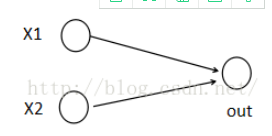
$$z=W*X+b$$
$$out=f(z)$$

然后现在maxout网络在这一层同时训练$k$组参数，然后选择激活值最大的作为下一层神经元的激活值，如取$k=3$：
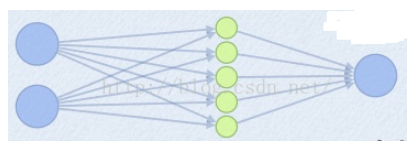
$$z_1=W_1*x+b_1$$
$$z_2=W_2*x+b_2$$
$$z_3=W_3*x+b_3$$
$$out=max(z_1,z_2,z_3)$$
所以，若采用maxout网络，参数个数将成$k$倍增加。

______
maxout可看成是一个激活函数，具有如下的性质：
1. maxout激活函数并不是一个固定的函数，不像sigmoid、relu、tanh等函数，是一个固定的函数方程。
2. 它是一个可学习的激活函数，因为$W$参数是学习变化的。
3. 它是一个分段线性函数。其拟合能力是非常强的，可拟合任意的凸函数。直观解释就是任意的凸函数都可以由分段线性函数以任意精度拟合。

```Python
#maxout 网络层类的定义
class MaxoutDense(Layer):
    # 网络输入数据矩阵大小为(nb_samples, input_dim)
    # 网络输出数据矩阵大小为(nb_samples, output_dim)
    input_ndim = 2
   #nb_feature就是我们前面说的k的个数了，这个是maxout层特有的参数
    def __init__(self, output_dim, nb_feature=4,
                 init='glorot_uniform', weights=None,
                 W_regularizer=None, b_regularizer=None, activity_regularizer=None,
                 W_constraint=None, b_constraint=None, input_dim=None, **kwargs):
        self.output_dim = output_dim
        self.nb_feature = nb_feature
        self.init = initializations.get(init)
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.constraints = [self.W_constraint, self.b_constraint]
 
        self.initial_weights = weights
        self.input_dim = input_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        self.input = K.placeholder(ndim=2)
        super(MaxoutDense, self).__init__(**kwargs)
    #参数初始化部分
    def build(self):
        input_dim = self.input_shape[1]
 
        self.W = self.init((self.nb_feature, input_dim, self.output_dim))#nb_feature是我们上面说的k。
        self.b = K.zeros((self.nb_feature, self.output_dim))
 
        self.params = [self.W, self.b]
        self.regularizers = []
 
        if self.W_regularizer:
            self.W_regularizer.set_param(self.W)
            self.regularizers.append(self.W_regularizer)
 
        if self.b_regularizer:
            self.b_regularizer.set_param(self.b)
            self.regularizers.append(self.b_regularizer)
 
        if self.activity_regularizer:
            self.activity_regularizer.set_layer(self)
            self.regularizers.append(self.activity_regularizer)
 
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
 
    def get_output(self, train=False):
        X = self.get_input(train)#需要切记这个x的大小是(nsamples,input_num) 
        # -- don't need activation since it's just linear.
        output = K.max(K.dot(X, self.W) + self.b, axis=1)#maxout激活函数
        return output
```

#### 参考文献
1. https://blog.csdn.net/hjimce/article/details/50414467
1. 《Maxout Network》

In [4]:
from keras.layers.core import Layer